#**DCGAN - Unsupervised Representation Learning With Deep Convolution Generative Adversarial Networks**

In this project, I have implemented the DCGAN Model. It is the most basic version of GAN with simple architecture(Few Convolution layers for discriminator and Upsampling or ConvTranspose layers for Generator)

**Original GAN Paper** : [GAN](https://arxiv.org/pdf/1406.2661.pdf)

**Deep Convolution GAN Paper** : [DCGAN](https://arxiv.org/pdf/1511.06434.pdf)

**Dataset Download** : [Celeb Faces](https://www.kaggle.com/jessicali9530/celeba-dataset)

**Special Note**

All file paths used below as specific to my system. Please change them accordingly if you are using the code as it is.

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import torch.nn.functional as F
from torchvision.utils import make_grid

import os
from torchvision.utils import save_image
import glob
import math 
import gc
import time
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

## **Downloading and Loading the data**

In [ ]:
batch_size = 128
latent_size = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle
%env KAGGLE_USERNAME= "Your Kaggle Username"
%env KAGGLE_KEY= "Your Kaggle API Key"

# %cd /content/drive/Mydrive      Uncomment this if you want to save it to your drive
!kaggle datasets download -d jessicali9530/celeba-dataset
!unzip "/content/celeba-dataset.zip"      # Change the folder name accordingly if you save the images in your drive

In [ ]:
def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

class Dataload(Dataset):
    def __init__(self, transform):
        self.transform = transform
        self.train_image = []
        self.train_image = sorted(glob.glob(os.path.join('/content/img_align_celeba/img_align_celeba', '*.jpg')))

    def __len__(self):
      return len(self.train_image)

    def __getitem__(self, index):
        img = pil_loader(self.train_image[index])
        img = self.transform(img)
        return img

transform = transforms.Compose([
                                transforms.Resize((64,80)),
                                transforms.CenterCrop(64),
                                transforms.ToTensor(),
                                transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
                                ])


train_dataset = Dataload(transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers = 2, drop_last=True)

## **Generative Adversarial Networks - DCGAN**

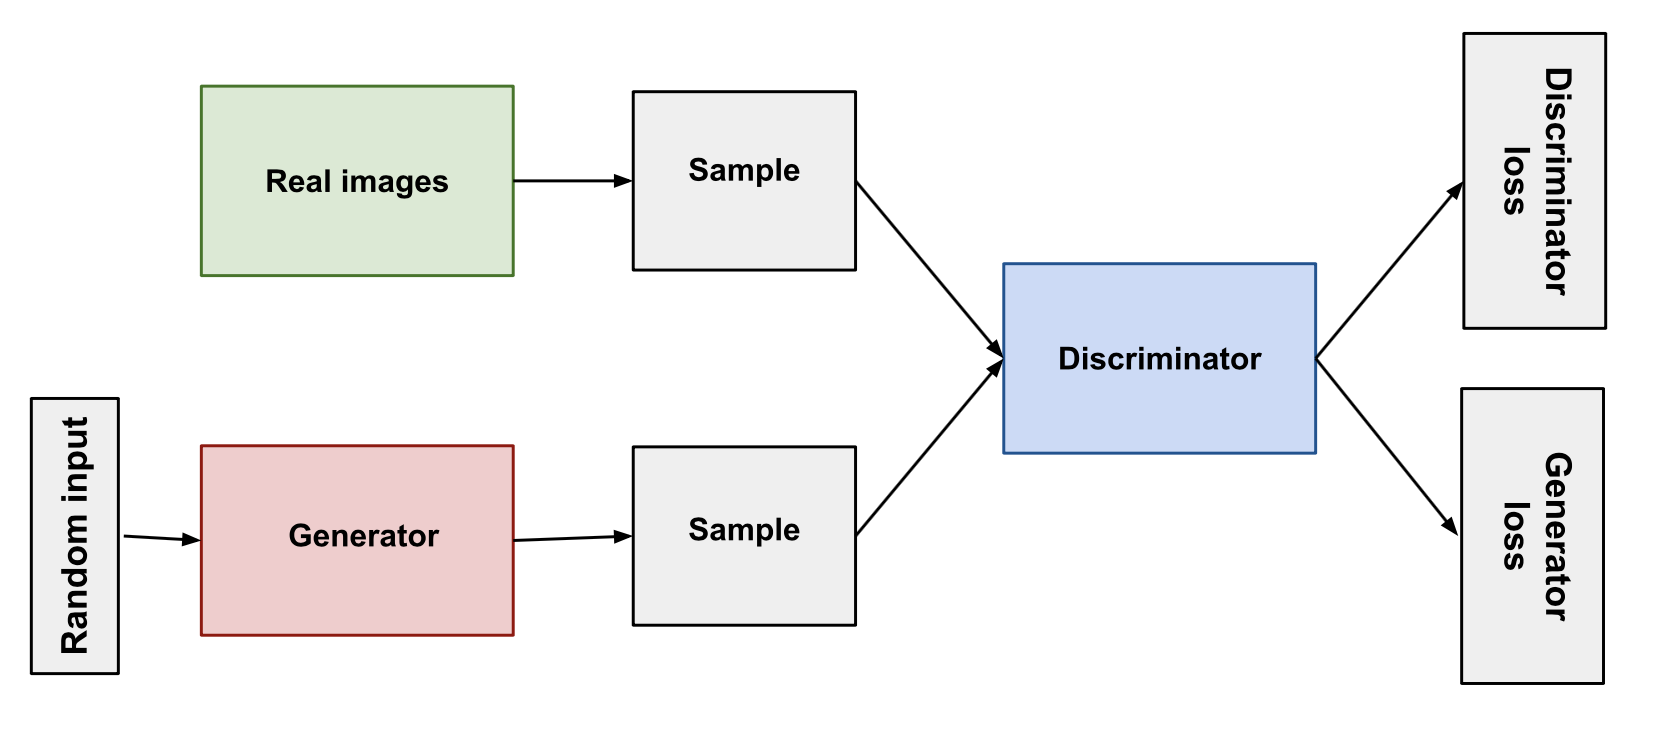

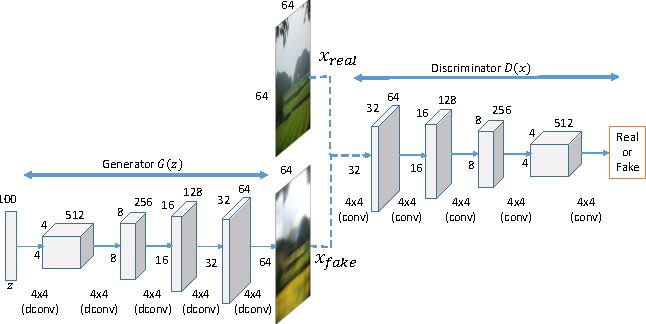

In [ ]:
# Initialising the weights for the generator and discriminator for stable training 

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.gen = nn.Sequential(

            # in: latent_size x 1 x 1
            
            nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # out: 512 x 4 x 4

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # out: 256 x 8 x 8

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # out: 128 x 16 x 16

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # out: 64 x 32 x 32

            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh(),
            # out: 3 x 64 x 64

        )
    
    def forward(self, x):
        x = x.to(device)
        return self.gen(x)


generator = Generator()

generator.to(device)

generator.apply(weights_init)

def get_model_summary(model, input_tensor_shape):
    summary(generator.to(device), input_tensor_shape)
get_model_summary(generator, (100, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.dis = nn.Sequential(
            # in: 3 x 64 x 64

            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 64 x 32 x 32

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 128 x 16 x 16

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 256 x 8 x 8

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 512 x 4 x 4

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            # out: 1 x 1 x 1
            nn.Flatten(),
            nn.Sigmoid())

    def forward(self, x):
        x = x.to(device)
        return self.dis(x)

discriminator = Discriminator()

discriminator.to(device)

discriminator.apply(weights_init)

def get_model_summary(model, input_tensor_shape):
    summary(discriminator.to(device), input_tensor_shape)
get_model_summary(discriminator, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,072
       BatchNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,288
       BatchNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-10            [-1, 512, 4, 4]           1,024
        LeakyReLU-11            [-1, 512, 4, 4]               0
           Conv2d-12              [-1, 1, 1, 1]           8,192
          Flatten-13                    [-1, 1]               0
          Sigmoid-14                   

## **Training**

In [ ]:
epoch_Dlosses = []             
epoch_Glosses = []
epoch_Real_Score = []
epoch_Fake_Score = []
epoch_Generator_Score = []

In [ ]:
epochs = 5
lr = 0.0002

optimizerD = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

# Loading the checkpoints if you need to continue from where you left

checkpoint = torch.load('/content/drive/MyDrive/generator_GANS_Celeb.pt')
generator.load_state_dict(checkpoint['model_state_dict'])
generator.to(device)
optimizerG.load_state_dict(checkpoint['optimizer_state_dict'])

checkpoint = torch.load('/content/drive/MyDrive/discriminator_GANS_Celeb.pt')
discriminator.load_state_dict(checkpoint['model_state_dict'])
discriminator.to(device)
optimizerD.load_state_dict(checkpoint['optimizer_state_dict'])

# Defining the Train function for Generator and Discriminator

def train_discriminator(real_images, optimizer):
    optimizer.zero_grad()

    real_images = real_images.to(device)
    real_pred = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0),1)
    real_pred = real_pred.to(device)
    real_targets = real_targets.to(device)
    real_loss = F.binary_cross_entropy(real_pred, real_targets)
    real_score = torch.mean(real_pred).item()
    z = torch.randn(batch_size, latent_size, 1, 1)
    z = z.to(device)
    fake_images = generator(z)
    fake_pred = discriminator(fake_images)
    fake_targets = torch.zeros(fake_images.size(0),1)
    fake_pred = fake_pred.to(device)
    fake_targets = fake_targets.to(device)
    fake_loss = F.binary_cross_entropy(fake_pred, fake_targets)
    fake_score = torch.mean(fake_pred).item()

    discriminator_loss = fake_loss + real_loss
    discriminator_loss.backward()
    optimizer.step()

    return discriminator_loss.item(), real_score, fake_score


def train_generator(optimizer):

    optimizer.zero_grad()

    z = torch.randn(batch_size, latent_size, 1, 1)
    z = z.to(device)
    generator_images = generator(z)
    generator_pred = discriminator(generator_images)
    generator_targets = torch.ones(batch_size, 1)
    generator_pred = generator_pred.to(device)
    generator_targets = generator_targets.to(device)
    generator_loss = F.binary_cross_entropy(generator_pred, generator_targets)
    generator_score = torch.mean(generator_pred).item()

    generator_loss.backward()
    optimizer.step()

    return generator_loss.item(), generator_score


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

# To save the images so as to keep a progress of the learning of Generator

sample_dir = '/content/drive/MyDrive/GAN Images/CelebA'
os.makedirs(sample_dir, exist_ok=True)
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

def save_samples(index1, index2, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{}-{}.png'.format(index1, index2)
    save_image((fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

# TRAINING

for epoch in range(epochs):
    
    start_time = time.monotonic()
    
    print(f"Epoch: {epoch + 1}")
    train_DLoss_batch = []
    train_GLoss_batch = []
    train_real_score = []
    train_fake_score = []
    train_generator_score = []

    for idx,(real_images) in enumerate(train_dataloader):
        discriminator_loss, real_score, fake_score = train_discriminator(real_images, optimizerD)
        generator_loss, generator_score = train_generator(optimizerG)
        train_DLoss_batch.append(discriminator_loss)
        train_GLoss_batch.append(generator_loss)
        train_real_score.append(real_score)
        train_fake_score.append(fake_score)
        train_generator_score.append(generator_score)
        if (idx+1)%100 == 0:
            print(f"Epoch [{(idx+1)//100}/15] Discriminator Batch Loss: {discriminator_loss:.5f}   Generator Batch Loss: {generator_loss:.5f}   Real Score: {real_score:.5f}   Fake Score: {fake_score}   Genrator Score: {generator_score:.5f}")
            save_samples(epoch+1, int(idx+1//100), fixed_latent, show=False)

    epoch_Dlosses.append(sum(train_DLoss_batch)/len(train_dataloader))
    epoch_Glosses.append(sum(train_GLoss_batch)/len(train_dataloader))
    epoch_Real_Score.append(sum(train_real_score)/len(train_dataloader))
    epoch_Fake_Score.append(sum(train_fake_score)/len(train_dataloader))
    epoch_Generator_Score.append(sum(train_generator_score)/len(train_dataloader))

    # Saving the Generator and Discriminator weights 
    
    torch.save({
        'epoch': epoch,
        'model_state_dict': discriminator.state_dict(),
        'optimizer_state_dict': optimizerD.state_dict(),
        'loss': epoch_Dlosses[-1],
        }, '/content/drive/MyDrive/discriminator_GANS_Celeb.pt')

    torch.save({
        'epoch': epoch,
        'model_state_dict': generator.state_dict(),
        'optimizer_state_dict': optimizerG.state_dict(),
        'loss': epoch_Glosses[-1],
        }, '/content/drive/MyDrive/generator_GANS_Celeb.pt')

    print(f"Epoch {epoch + 1} Training Over")
    print(f"Discriminator Epoch Loss: {epoch_Dlosses[-1]:.5f}   Generator Epoch Loss: {epoch_Glosses[-1]:.5f}   Real Score: {epoch_Real_Score[-1]:.5f}   Fake Score: {epoch_Fake_Score[-1]:.5f}   Generator Score: {epoch_Generator_Score[-1]:.5f}")

    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.empty_cache()
    gc.collect()
    print("\n\n\n TIME TAKEN FOR THE EPOCH: {} mins and {} seconds".format(epoch_mins, epoch_secs))
    

print("OVERALL TRAINING COMPLETE")

Epoch: 1
Epoch [1/15] Discriminator Batch Loss: 0.39216   Generator Batch Loss: 7.66730   Real Score: 0.78785   Fake Score: 0.02454359084367752   Genrator Score: 0.00431
Epoch [2/15] Discriminator Batch Loss: 0.65423   Generator Batch Loss: 3.88490   Real Score: 0.75778   Fake Score: 0.1925535500049591   Genrator Score: 0.03548
Epoch [3/15] Discriminator Batch Loss: 0.87069   Generator Batch Loss: 5.29737   Real Score: 0.96342   Fake Score: 0.4742690324783325   Genrator Score: 0.01061
Epoch [4/15] Discriminator Batch Loss: 0.68586   Generator Batch Loss: 5.97734   Real Score: 0.88184   Fake Score: 0.3682366907596588   Genrator Score: 0.00670
Epoch [5/15] Discriminator Batch Loss: 0.57584   Generator Batch Loss: 2.50393   Real Score: 0.68110   Fake Score: 0.04717499017715454   Genrator Score: 0.14814
Epoch [6/15] Discriminator Batch Loss: 0.96115   Generator Batch Loss: 6.16520   Real Score: 0.89402   Fake Score: 0.4326403737068176   Genrator Score: 0.00556
Epoch [7/15] Discriminator Ba

### **Plotting**

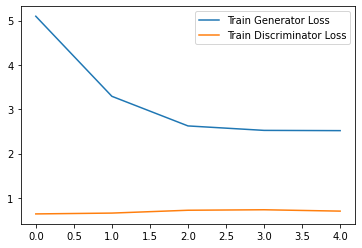

In [ ]:
plt.plot(epoch_Glosses, label = 'Train Generator Loss')
plt.plot(epoch_Dlosses, label = 'Train Discriminator Loss')
plt.legend()
plt.show()

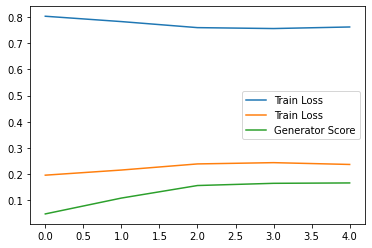

In [ ]:
plt.plot(epoch_Real_Score, label = 'Train Loss')
plt.plot(epoch_Fake_Score, label = 'Train Loss')
plt.plot(epoch_Generator_Score, label = 'Generator Score')
plt.legend()
plt.show()

## **Testing**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


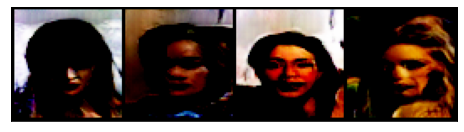

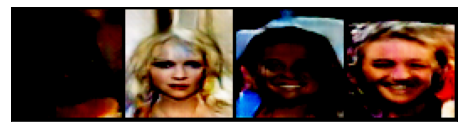

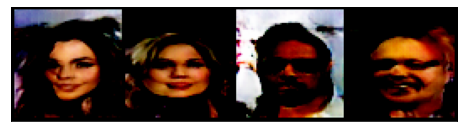

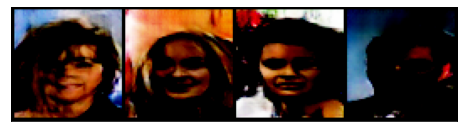

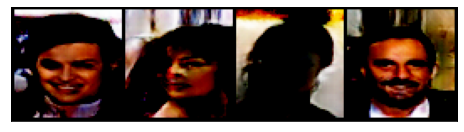

In [ ]:
for i in range(5):
    latent = torch.randn(4, latent_size, 1, 1, device=device)
    save_samples(9999, 1, latent, show=True)

### **Results**

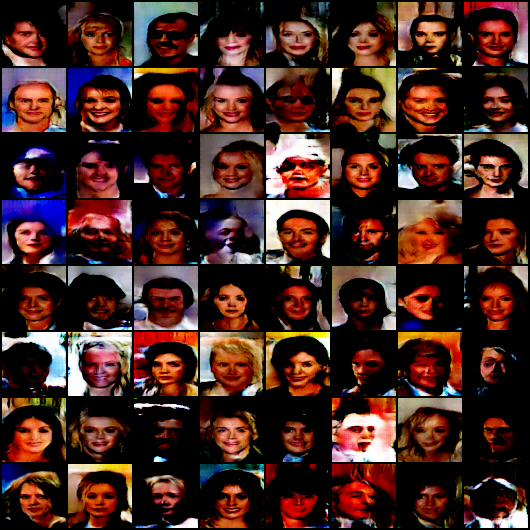

You can check out a GIF animation on how the Generator learns to generate human faces : [GitHub Repo](https://github.com/Vinayak-VG/My-Projects/tree/main/Computer_Vision_Projects/Generative_Adversarial_Networks-GAN/DCGAN)

## **End Note**


Here you go! We have successfully implemented Generative Adversarial Networks. This is a very simple version of GAN( DCGAN ). There has been a lot of advancement in the field of GANs and you can definitely check out the complex models and how they are able to generate high resolution images.

Here's a list of things which you can try it out and experiment

1. StarGAN

2. StackGAN

3. StyleGAN

Problems with GANs: There are a lots of problems while training a GAN. These are a few which come while training a GAN. I would suggest you look up these problems and try to reason out why that may happen and you could refer the internet for solution to the problem :)

1. Mode Collapse: It is the state when the Generator outputs only a same kind of images. Basically it overfits to a very small distribution in the real dataset.

2. Vanishing Gradients
